In [ ]:
## Download the database

#  wget 'http://groups.csail.mit.edu/cb/cablastp/cablastp-nr20130630.tar.gz'
#  tar xf cablastp-nr20130630.tar.gz

In [ ]:
# Show plots as part of the notebook and make tools available
%matplotlib inline
import matplotlib.pyplot as plt

# Standard library packages
import os

# Import Numpy, Pandas and Seaborn
import numpy as np
import pandas as pd
import seaborn as sns

# Import Biopython tools for running local BLASTX
from Bio.Blast.Applications import NcbiblastpCommandline

# Colour scale transformation
from matplotlib.colors import LogNorm

In [ ]:
# Input and output dir
datadir = "blast-p-data-in-human-yeast"
outdir = "blast-p-data-out-human-yeast"

s1 = os.path.join(datadir, "blast-p-data-in-human-yeast/biogrid_Human_ID_9606_sequences.fasta")
s2 = os.path.join(datadir, "blast-p-data-in-human-yeast/biogrid_Yeast_ID_559292_sequences.fasta")

fwd_out = os.path.join(outdir, "05-fwd-results.tab")
rev_out = os.path.join(outdir, "05-rev-results.tab")

In [ ]:
# Create BLAST command-lines for forward and reverse BLAST searches
fwd_blastp = NcbiblastpCommandline(query=s1, subject=s2, out=fwd_out,
                                   outfmt="\'6 qseqid sseqid pident qcovs qlen slen length bitscore evalue\'",
                                   max_target_seqs=1)
rev_blastp = NcbiblastpCommandline(query=s2, subject=s1, out=rev_out,
                                   outfmt="\'6 qseqid sseqid pident qcovs qlen slen length bitscore evalue\'",
                                   max_target_seqs=1)

# Inspect command-lines
print("FORWARD: %s" % fwd_blastp)
print("REVERSE: %s" % rev_blastp)

# Forward blastp

!../binaries/ncbi-blast-2.13.0+/bin/blastp -out blast-p-data-out-human-yeast/05-fwd-results.tab -outfmt 6 -query blast-p-data-in-human-yeast/biogrid_Human_ID_9606_sequences.fasta -max_target_seqs 1 -subject blast-p-data-in-human-yeast/biogrid_Yeast_ID_559292_sequences.fasta

In [20]:
# Reverse blastp
# num_threads 
!../binaries/ncbi-blast-2.13.0+/bin/blastp --help# -out biogrid_Yeast_ID_559292_sequences.fasta -max_target_seqs 1 -subject blast-p-data-in-human-yeast/biogrid_Human_ID_9606_sequences.fasta

USAGE
  blastp [-h] [-help] [-import_search_strategy filename]
    [-export_search_strategy filename] [-task task_name] [-db database_name]
    [-dbsize num_letters] [-gilist filename] [-seqidlist filename]
    [-negative_gilist filename] [-negative_seqidlist filename]
    [-taxids taxids] [-negative_taxids taxids] [-taxidlist filename]
    [-negative_taxidlist filename] [-ipglist filename]
    [-negative_ipglist filename] [-entrez_query entrez_query]
    [-db_soft_mask filtering_algorithm] [-db_hard_mask filtering_algorithm]
    [-subject subject_input_file] [-subject_loc range] [-query input_file]
    [-out output_file] [-evalue evalue] [-word_size int_value]
    [-gapopen open_penalty] [-gapextend extend_penalty]
    [-qcov_hsp_perc float_value] [-max_hsps int_value]
    [-xdrop_ungap float_value] [-xdrop_gap float_value]
    [-xdrop_gap_final float_value] [-searchsp int_value] [-seg SEG_options]
    [-soft_masking soft_masking] [-matrix matrix_name]
    [-threshold float_value] [-c

**Loading BLAST results**

Once the BLAST searches are finished, you can load the tabular format results into two pandas dataframes, so that the output can be modified and inspected.

The BLAST output does not come with column headers in the file, so we have to add these ourselves, to match the columns requested in the original BLAST query.

<p></p>
<div class="alert-success">
The cell below loads in pre-calculated results, to save lesson time. To use results calculated by the cell above, comment out the lines defining `fwd_out` and `rev_out`.</div>

In [ ]:
# Load the BLAST results into Pandas dataframes
fwd_results = pd.read_csv(fwd_out, sep="\t", header=None)
rev_results = pd.read_csv(rev_out, sep="\t", header=None)

# Add headers to forward and reverse results dataframes
headers = ["query", "subject", "identity", "coverage",
           "qlength", "slength", "alength",
           "bitscore", "E-value"]
fwd_results.columns = headers
rev_results.columns = headers

**Normalised bit score, and coverage**

<p></p>
<div class="alert-success">
Before you examine the `BLAST` results themselves, it is useful to define a new quantity: the normalised bitscore.
</div>

<p></p>
The bitscore reported by BLAST is the sum of the qualities of the aligned symbols over the whole alignment. This is an accurate measure of the alignment strength, but long sequences tend to have higher bitscores than short sequences, even when the matches are of about the same quality. To correct for this length effect, we can calculate a normalised bitscore where:

$$\mathrm{normalised\ bitscore = \frac{bitscore}{query\ length}}$$

This makes comparisons of bitscore between proteins of different lengths fairer.


Calculations using pandas columns

Rather than looping over every item in a pandas dataframe column, it is possible to carry out calculations on entire columns in one action. So, to divide the contents of the bitscore column by the contents of the qlength column in the fwd_results dataframe, on a row-by-row basis, we can use the Python code:

$$\mathrm{norm\_bitscore = fwd\_results.bitscore/fwd\_results.qlength}$$

<p></p>
<div class="alert-success">
You will also find it useful to consider two types of coverage: query coverage and alignment coverage.
</div>
    
The query and subject sequences in a BLAST alignment may not be of the same length, so it is possible that an alignment that covers the whole of one of the sequences may only cover a small part of the other sequence (e.g. if the query sequence is a single domain protein, and that domain is part of a multi-domain protein subject sequence). That is to say, for the same alignment, the coverage of the query and the subject sequences can differ. BLAST+ only reports the query coverage, so we must calculate subject coverage ourselves.

We can define two more columns in the dataframe:

$$\mathrm{query\ coverage=\frac{alignment\ length}{query\ length}}$$
$$\mathrm{subject\ coverage=\frac{alignment\ length}{subject\ length}}$$

In [ ]:
# Create a new column in both dataframes: normalised bitscore
fwd_results['norm_bitscore'] = fwd_results.bitscore/fwd_results.qlength
rev_results['norm_bitscore'] = rev_results.bitscore/rev_results.qlength

# Create query and subject coverage columns in both dataframes
fwd_results['qcov'] = fwd_results.alength/fwd_results.qlength
rev_results['qcov'] = rev_results.alength/rev_results.qlength
fwd_results['scov'] = fwd_results.alength/fwd_results.slength
rev_results['scov'] = rev_results.alength/rev_results.slength

# Clip maximum coverage values at 1.0
fwd_results['qcov'] = fwd_results['qcov'].clip_upper(1)
rev_results['qcov'] = rev_results['qcov'].clip_upper(1)
fwd_results['scov'] = fwd_results['scov'].clip_upper(1)
rev_results['scov'] = rev_results['scov'].clip_upper(1)

In [ ]:
# Inspect the forward results data
fwd_results.head()

In [ ]:
# Inspect the reverse results data
rev_results.head()

**Visualising one-way match results**

<p></p>
<div class="alert-success">
Each result dataframe contains one row per query sequence, showing the best match, and some properties of the sequence alignment.
</div>

Using the seaborn package, you can summarise elements of this data visually, to get some insight into an organism-vs-organism BLAST search. For instance, a single line of code can produce a distribution plot (kernel density estimate, and histogram) of the bitscore for each BLAST hit. The bitscore encapsulates the quality of the match, and is a single measure that reflects the number of similar residues in the alignment, and their similarity.


NameError: name 'fwd_results' is not defined

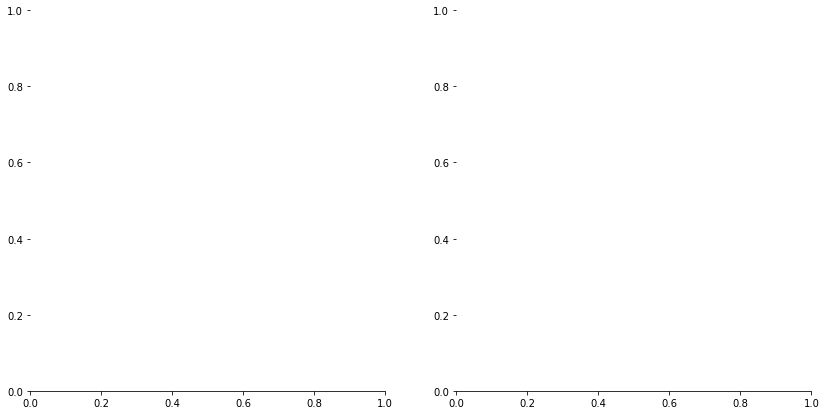

In [19]:
# Set up the figure
f, axes = plt.subplots(1, 2, figsize=(14, 7), sharex=True)
sns.despine(left=True)

# Plot distribution of forward and reverse hit bitscores
sns.distplot(fwd_results.norm_bitscore, color="b", ax=axes[0], axlabel="forward normalised bitscores")
sns.distplot(rev_results.norm_bitscore, color="g", ax=axes[1], axlabel="reverse normalised bitscores");

**The two plots that result from this code show the distributions of the one-way best hit BLAST bitscores.**

<p></p>
<div class="alert-success">
The first thing you have probably noticed is that the distributions are *bimodal*: most hits lie in the main bulk of the distribution, but in both the forward and reverse searches there is a relatively small set of matches that have a low bitscore. These are likely to be low-quality matches that are either very short, sequence-dissimilar, or both.
</div>
    
**A second plot that is useful for interpretation is the heatmap/2D density plot of query sequence coverage and subject sequence coverage:**

In [ ]:
# Plot 2D density histograms
# !! YOU DO NOT NEED TO UNDERSTAND THIS CODE TO FOLLOW THE LESSON !!

# Calculate 2D density histograms for counts of matches at several coverage levels
(Hfwd, xedgesf, yedgesf) = np.histogram2d(fwd_results.qcov, fwd_results.scov, bins=20)
(Hrev, xedgesr, yedgesr) = np.histogram2d(rev_results.qcov, rev_results.scov, bins=20)

# Create a 1x2 figure array
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharex=True, sharey=True)

# Plot histogram for forward matches
im = axes[0].imshow(Hfwd, cmap=plt.cm.Blues, norm=LogNorm(),
                    extent=[xedgesf[0], xedgesf[-1], yedgesf[0], yedgesf[-1]],
                    origin='lower', aspect=1)
axes[0].set_title("Forward")
axes[0].set_xlabel("query")
axes[0].set_ylabel("subject")

# Plot histogram for reverse matches
im = axes[1].imshow(Hrev, cmap=plt.cm.Blues, norm=LogNorm(),
                    extent=[xedgesr[0], xedgesr[-1], yedgesr[0], yedgesr[-1]],
                    origin='lower', aspect=1)
axes[1].set_title("Reverse")
axes[1].set_xlabel("query")
axes[1].set_ylabel("subject")

# Add colourbars
fig.colorbar(im, ax=axes[0])
fig.colorbar(im, ax=axes[1]);

%run -i perform_reciprocal_blast.py --blast_loc ../binaries/ncbi-blast-2.13.0+/bin/blastp --no_threads_for_blast 1 --source_fasta blast-p-data-in-human-yeast/biogrid_Human_ID_9606_sequences.fasta --target_fasta blast-p-data-in-human-yeast/biogrid_Yeast_ID_559292_sequences.fasta --out_forward forward.log --out_reverse reverse.log --final_op output.tsv --verbose

In [74]:
!../binaries/ncbi-blast-2.13.0+/bin/blastp -out forward.log -outfmt 6 -query blast-p-data-in-human-yeast/biogrid_Human_ID_9606_sequences.fasta -subject blast-p-data-in-human-yeast/biogrid_Yeast_ID_559292_sequences.fasta -num_threads 1

^C
